In [11]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# Set plotting styles
plt.style.use('bmh')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 6]

In [12]:
# Load Processed Data from the Pipeline

# Get the current notebook directory and construct the correct path
notebook_dir = Path().absolute()
project_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
processed_data_path = project_root / 'processed_data' / 'final_processed_data.csv'

print(f"Looking for data file at: {processed_data_path}")
df = pd.read_csv(processed_data_path)

# Display basic information about the processed dataset
print("Dataset Overview:")
print("=" * 80)
print(f"\nShape: {df.shape}")
print("\nFeatures:")
for col in df.columns:
    dtype = df[col].dtype
    missing = df[col].isnull().sum()
    print(f"- {col}: {dtype} (Missing: {missing})")

Looking for data file at: /Users/katejohnson/Documents/Other/Northeastern/CS6140/Course Project/cs6140-course-project/processed_data/final_processed_data.csv
Dataset Overview:

Shape: (643, 31)

Features:
- year: float64 (Missing: 0)
- hydro_generation: float64 (Missing: 0)
- biofuel_generation: float64 (Missing: 0)
- solar_generation: float64 (Missing: 0)
- geothermal_generation: float64 (Missing: 0)
- country: object (Missing: 0)
- total_energy_consumption: float64 (Missing: 0)
- renewable_share_pct: float64 (Missing: 0)
- other_renewable_generation: float64 (Missing: 0)
- solar_generation_alt: float64 (Missing: 0)
- wind_generation: float64 (Missing: 0)
- hydro_generation_alt: float64 (Missing: 0)
- renewable_generation: float64 (Missing: 0)
- decade: float64 (Missing: 0)
- period: object (Missing: 0)
- renewable_generation_lag_1: float64 (Missing: 38)
- renewable_generation_lag_3: float64 (Missing: 114)
- renewable_generation_lag_6: float64 (Missing: 223)
- renewable_generation_lag

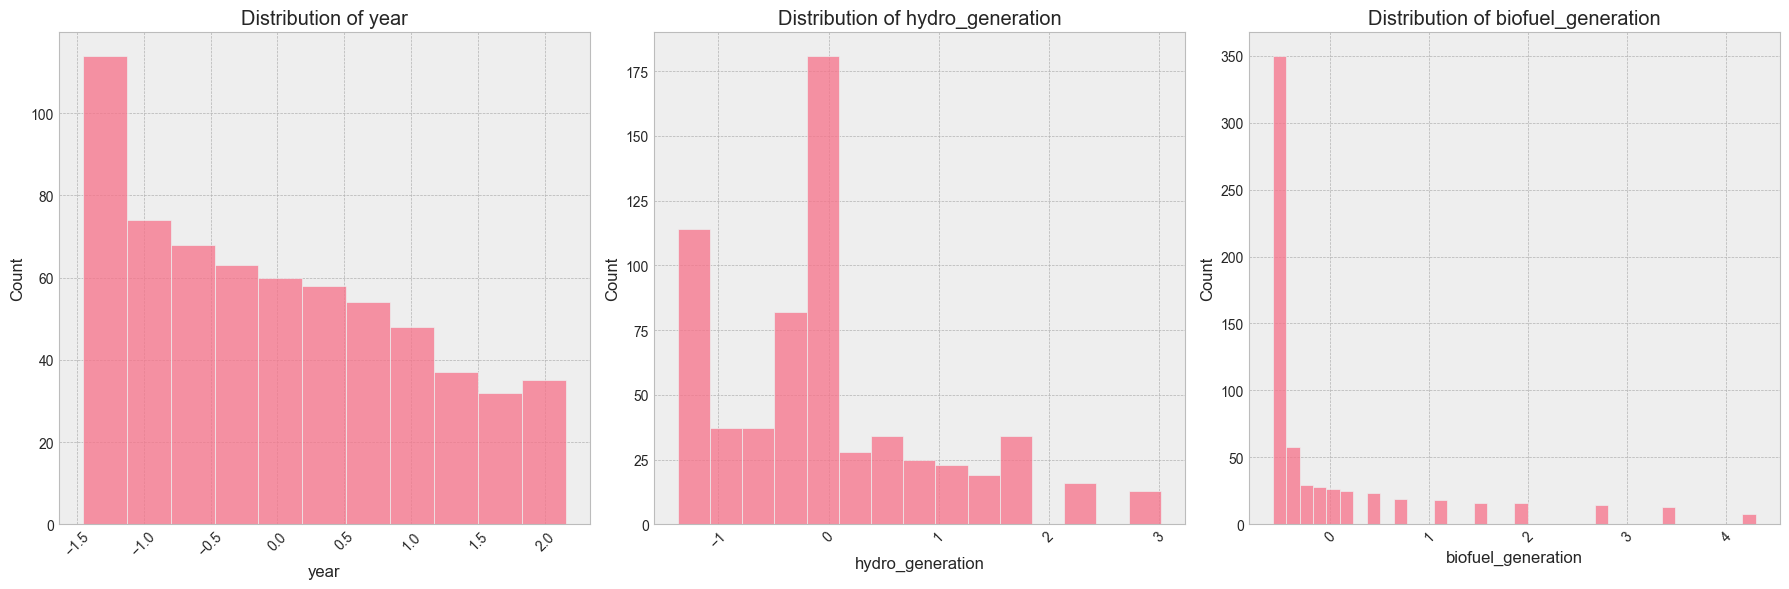

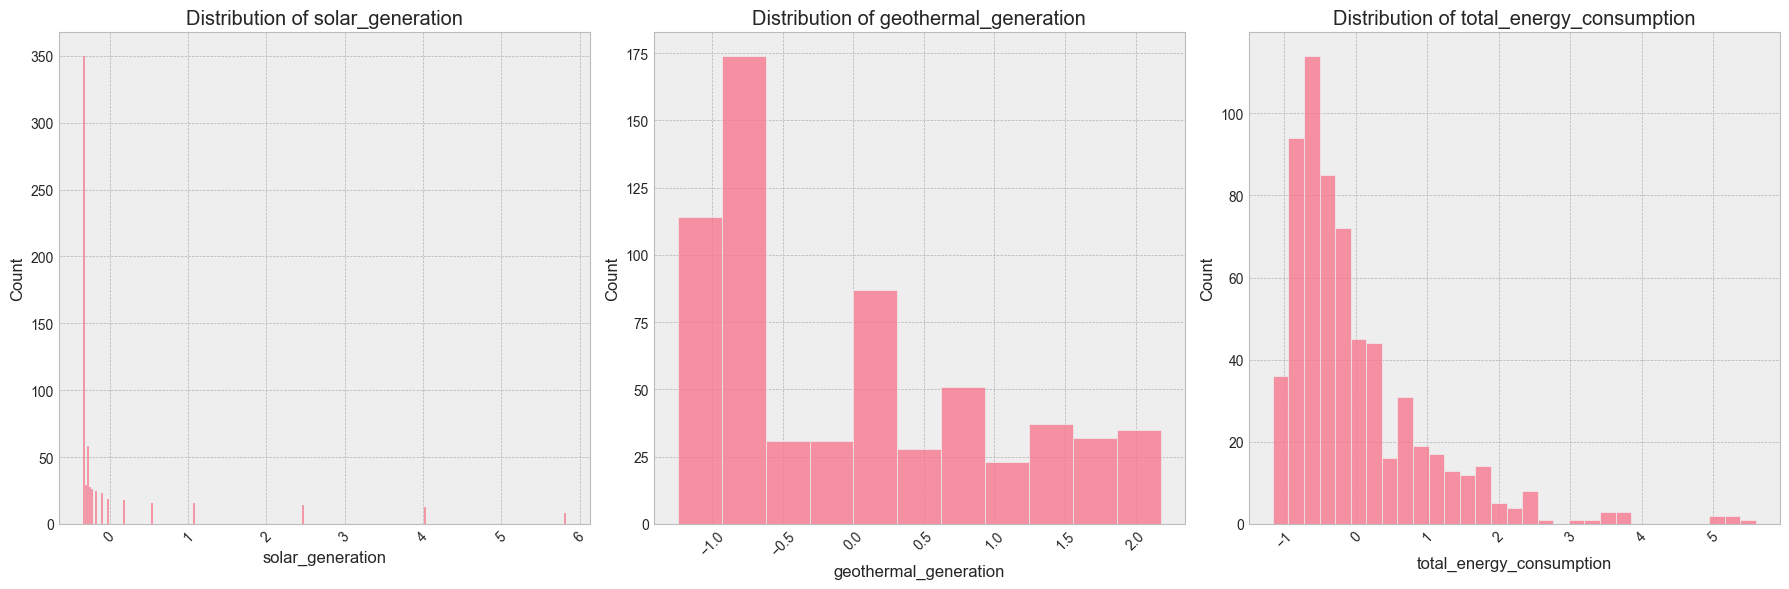

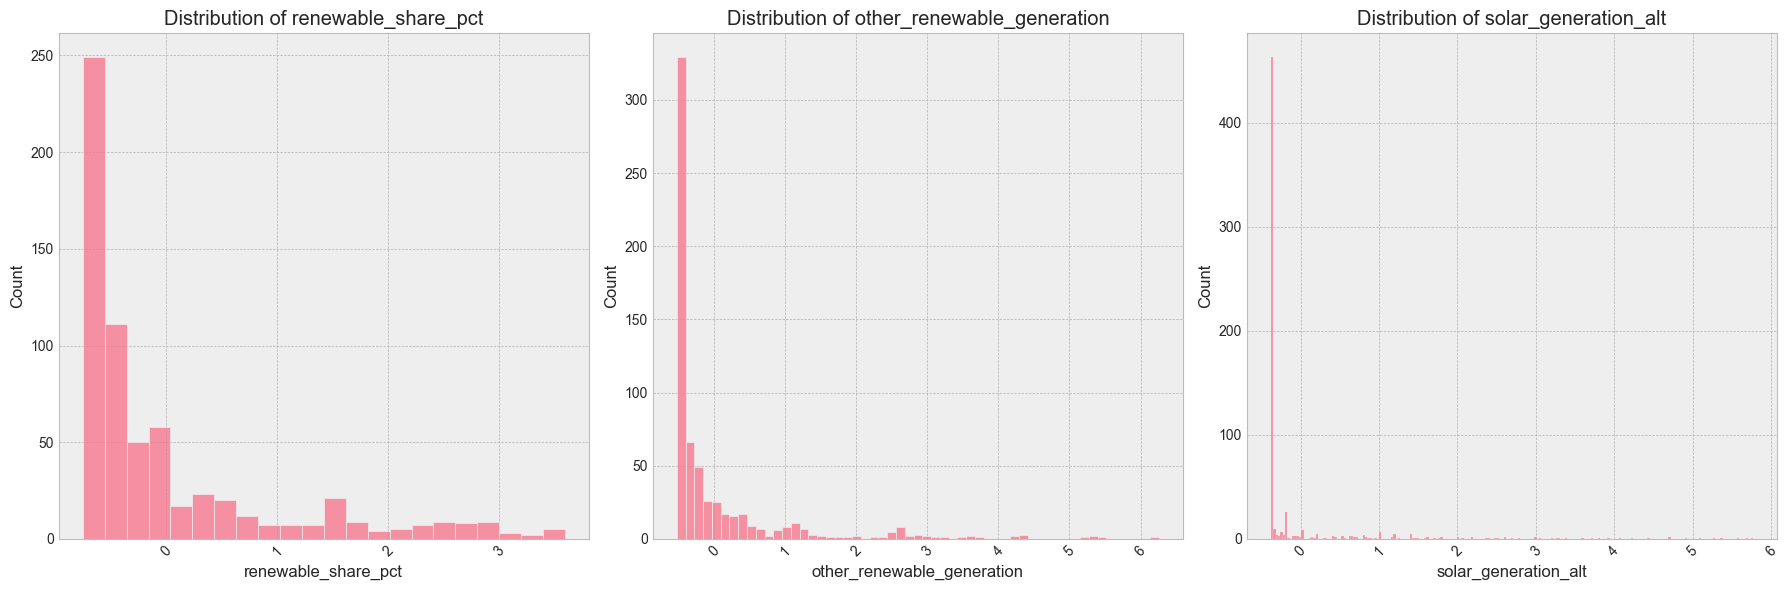

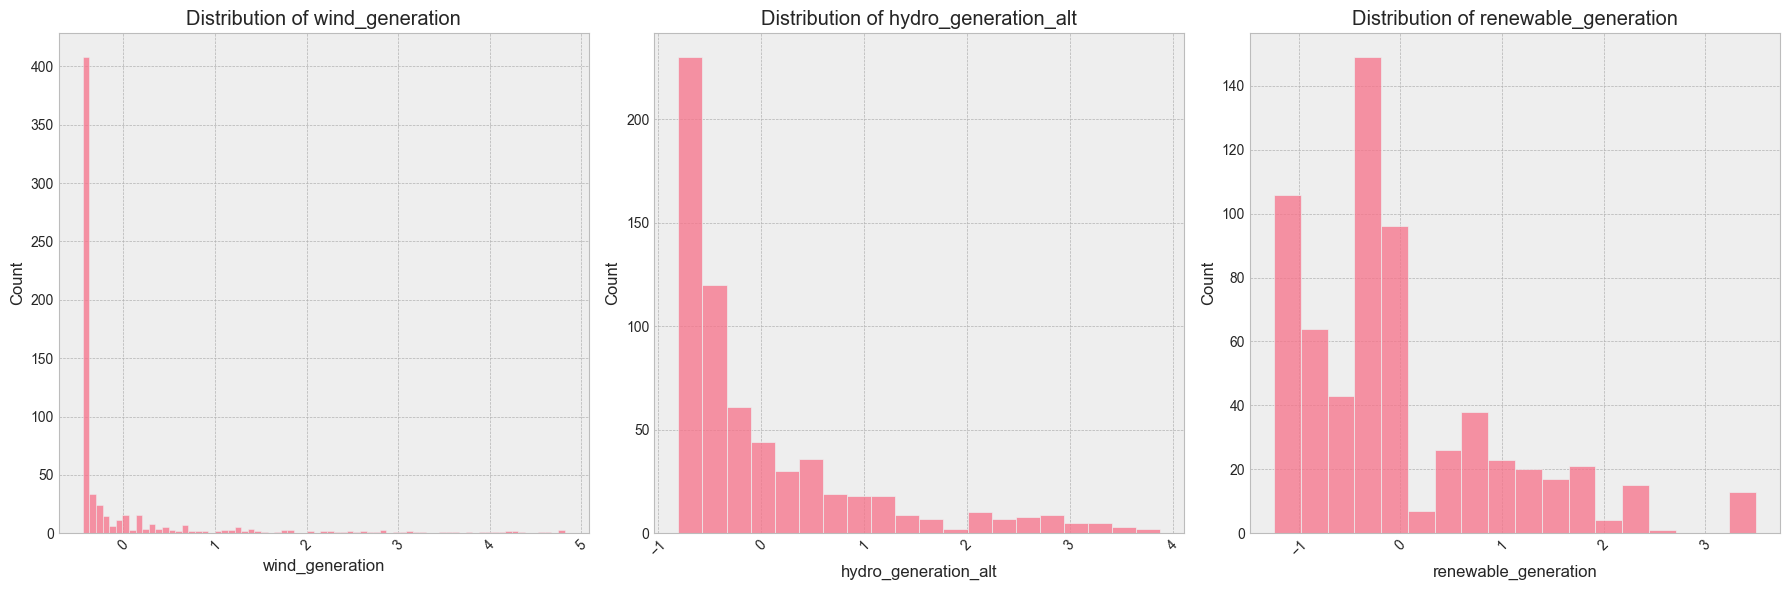

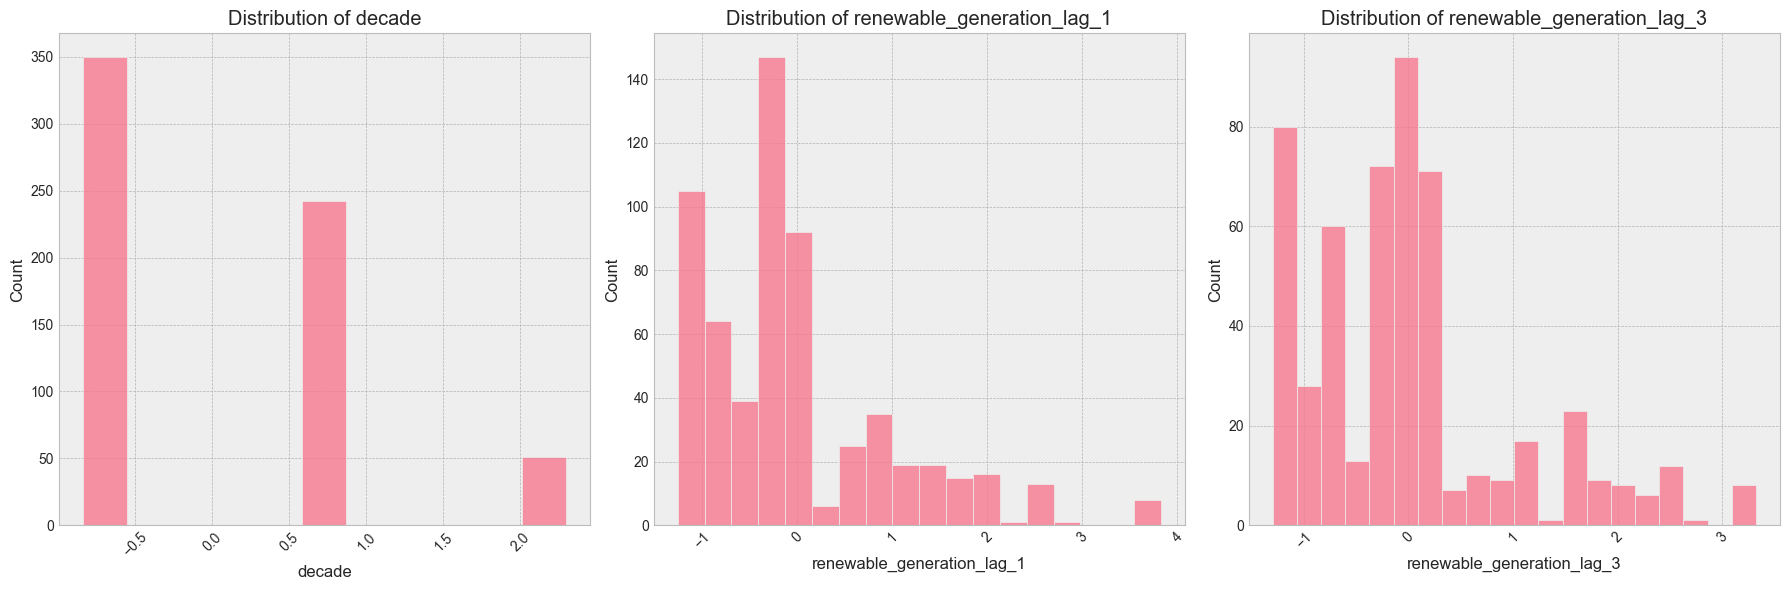

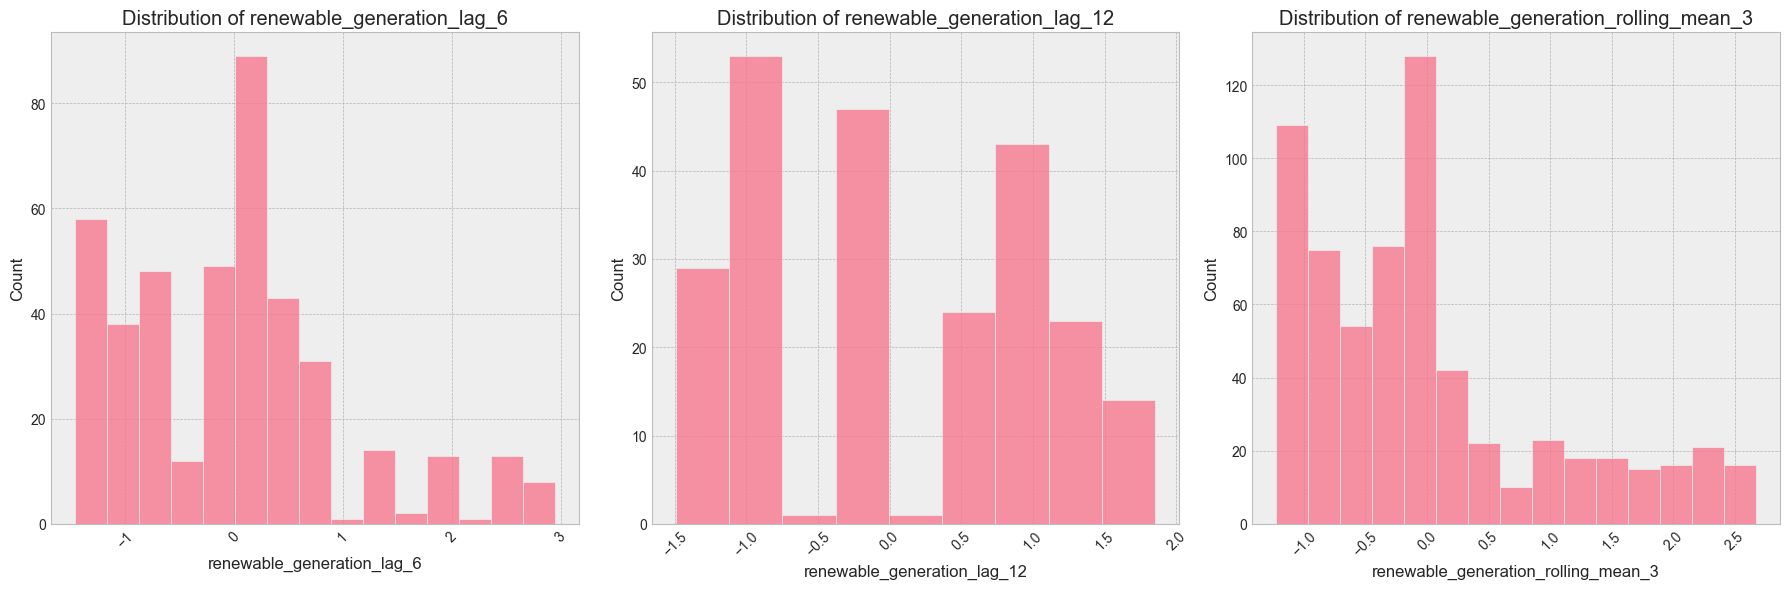

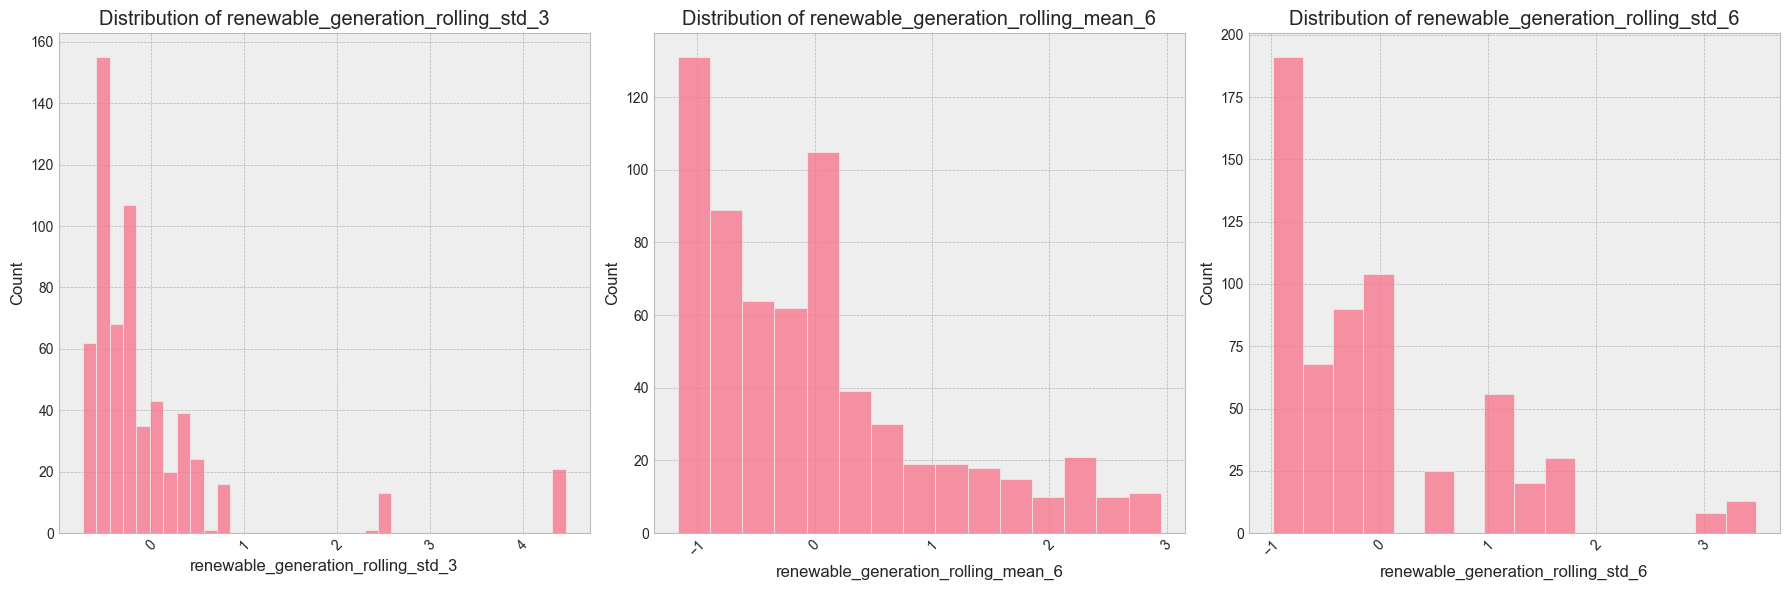

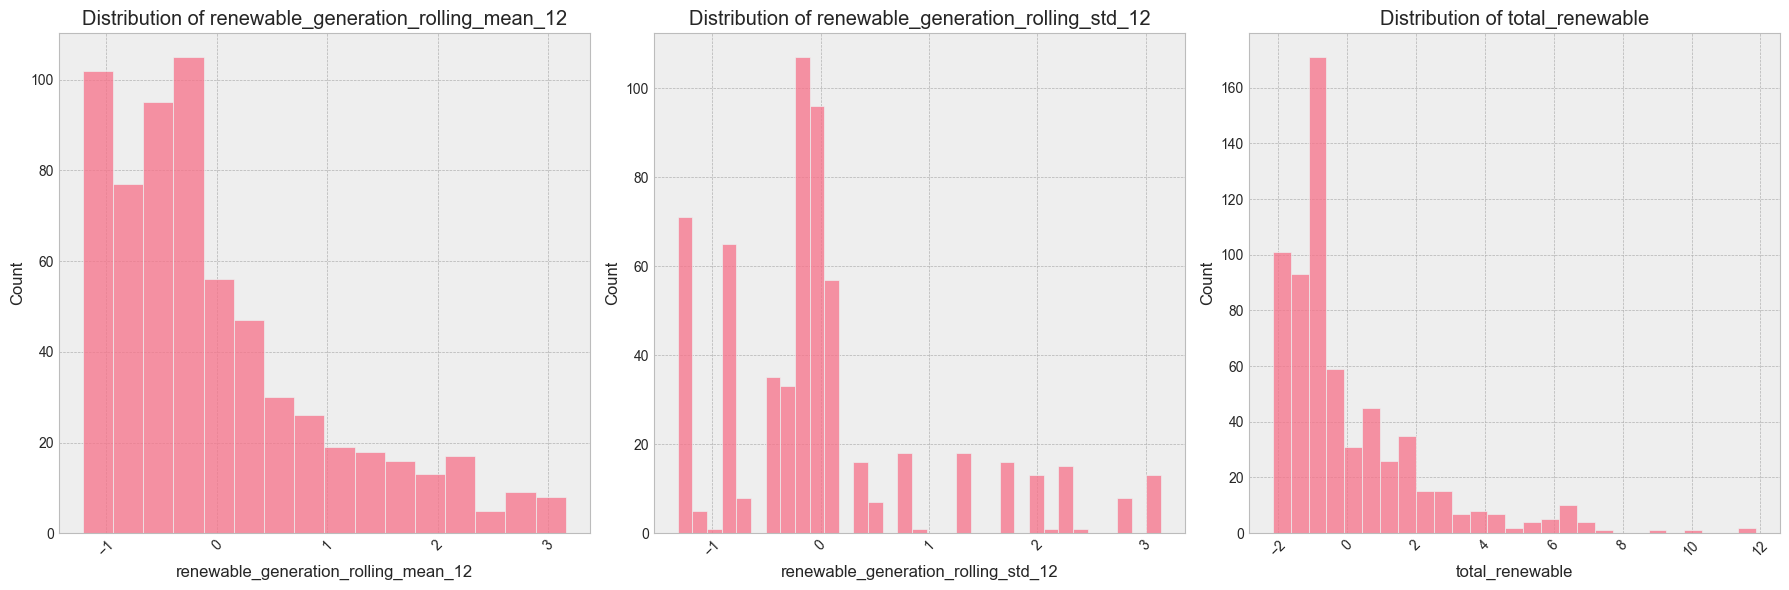

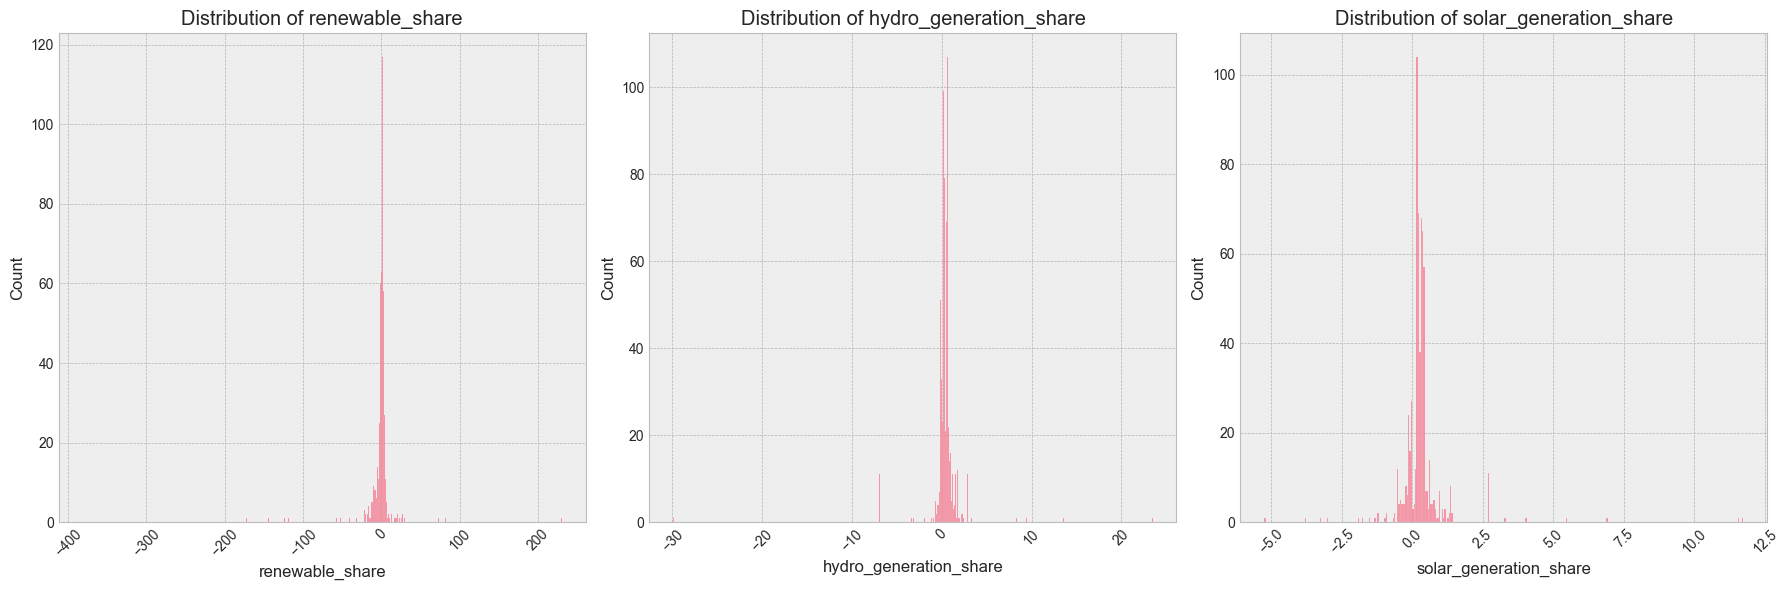

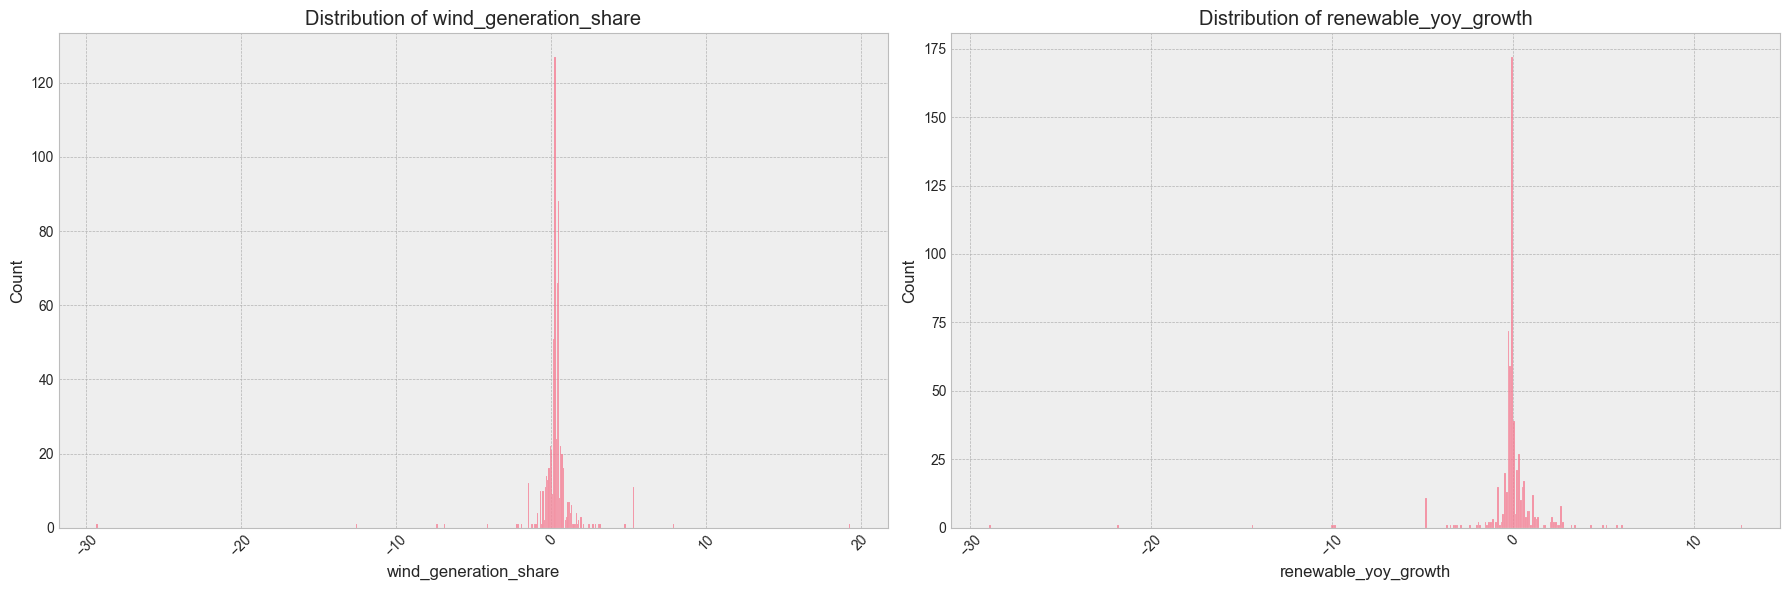


Normality Test Results:


,statistic,p_value
year,113.226438,2.589354e-25
hydro_generation,80.844695,2.784822e-18
biofuel_generation,329.399574,2.963407e-72
solar_generation,566.506611,9.652782e-124
geothermal_generation,100.253547,1.699099e-22
total_energy_consumption,298.909736,1.237586e-65
renewable_share_pct,203.481938,6.523168e-45
other_renewable_generation,429.997125,4.239462e-94
solar_generation_alt,486.426367,2.365138e-106
wind_generation,404.734225,1.297418e-88


In [13]:
# Feature Distribution Analysis
def analyze_feature_distributions():
    """Analyze the distribution of engineered features"""

    # Select numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Create distribution plots
    for i in range(0, len(numeric_cols), 3):
        cols = numeric_cols[i:i + 3]
        fig, axes = plt.subplots(1, len(cols), figsize=(18, 6))
        if len(cols) == 1:
            axes = [axes]

        for ax, col in zip(axes, cols):
            sns.histplot(data=df, x=col, ax=ax)
            ax.set_title(f'Distribution of {col}')
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    # Test for normality
    normality_tests = {}
    for col in numeric_cols:
        stat, p_value = stats.normaltest(df[col].dropna())
        normality_tests[col] = {'statistic': stat, 'p_value': p_value}

    return pd.DataFrame(normality_tests).T


# Run distribution analysis
distribution_results = analyze_feature_distributions()
print("\nNormality Test Results:")
display(distribution_results)

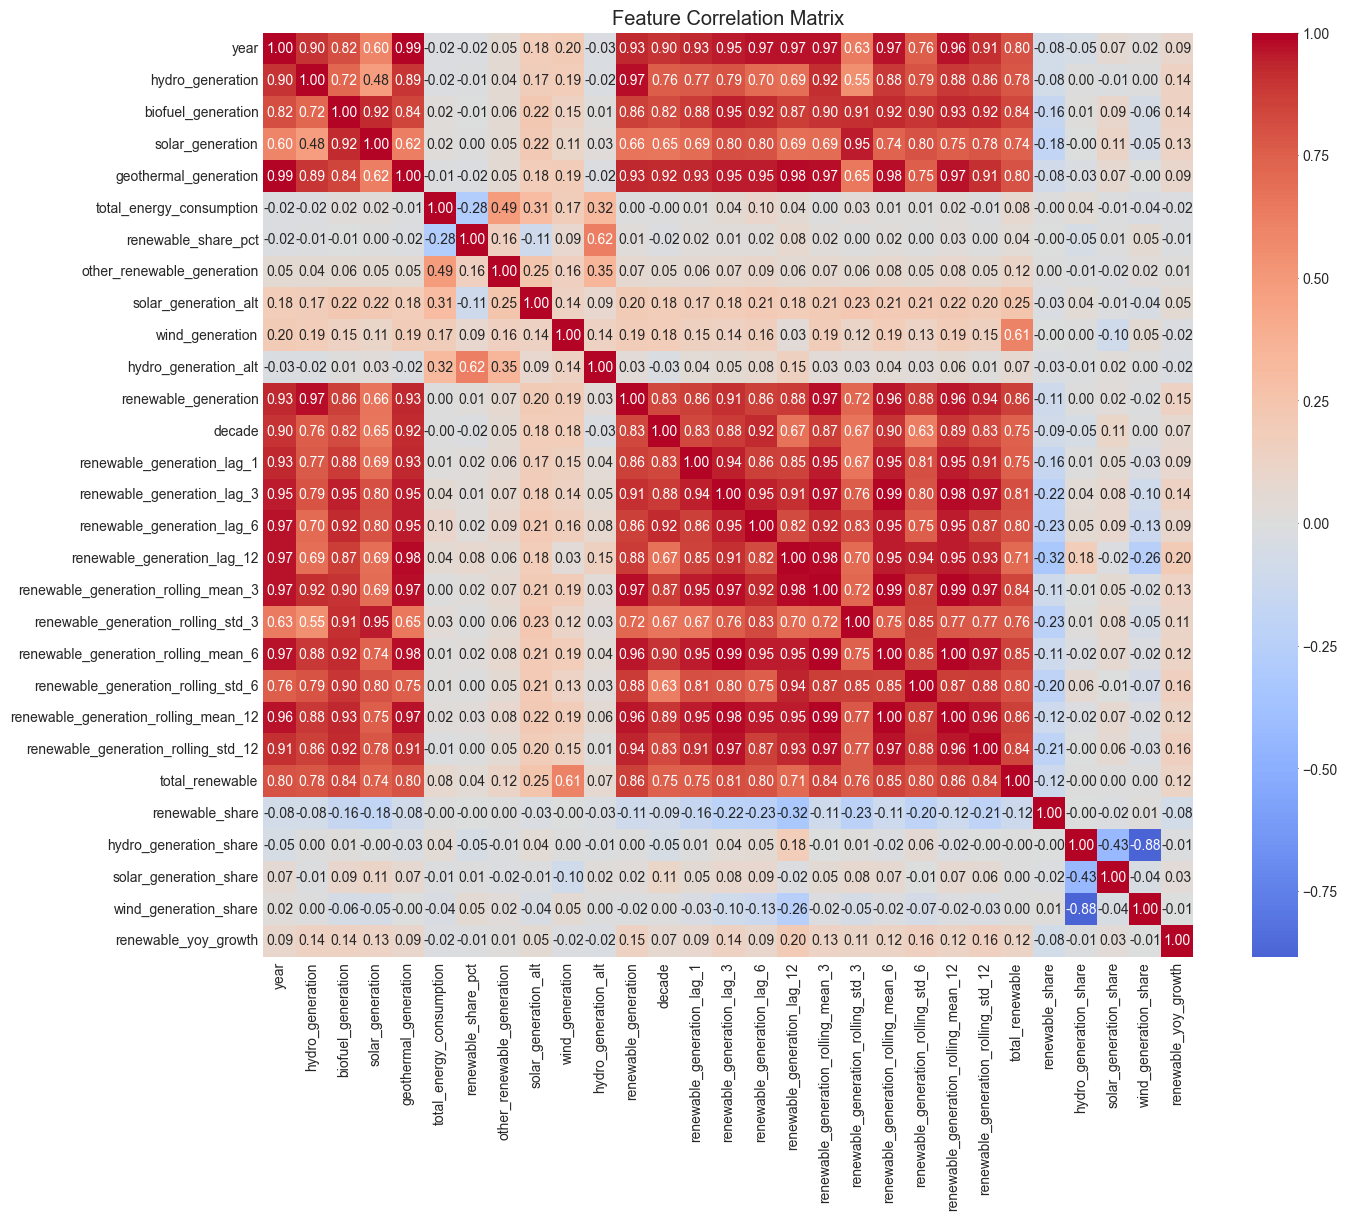


Highly Correlated Feature Pairs (|correlation| > 0.8):
year - hydro_generation: 0.901
year - biofuel_generation: 0.815
year - geothermal_generation: 0.989
year - renewable_generation: 0.932
year - decade: 0.902
year - renewable_generation_lag_1: 0.932
year - renewable_generation_lag_3: 0.955
year - renewable_generation_lag_6: 0.966
year - renewable_generation_lag_12: 0.970
year - renewable_generation_rolling_mean_3: 0.968
year - renewable_generation_rolling_mean_6: 0.967
year - renewable_generation_rolling_mean_12: 0.964
year - renewable_generation_rolling_std_12: 0.911
hydro_generation - year: 0.901
hydro_generation - geothermal_generation: 0.890
hydro_generation - renewable_generation: 0.971
hydro_generation - renewable_generation_rolling_mean_3: 0.916
hydro_generation - renewable_generation_rolling_mean_6: 0.885
hydro_generation - renewable_generation_rolling_mean_12: 0.882
hydro_generation - renewable_generation_rolling_std_12: 0.856
biofuel_generation - year: 0.815
biofuel_genera

In [14]:
# Correlation Analysis
def analyze_correlations():
    """Analyze correlations between features"""

    # Filter out non-numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    df_numerical = df[numerical_cols]

    # Calculate correlation matrix
    corr_matrix = df_numerical.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.show()

    # Identify highly correlated features
    high_corr = np.where(np.abs(corr_matrix) > 0.8)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y]

    print("\nHighly Correlated Feature Pairs (|correlation| > 0.8):")
    for feat1, feat2, corr in high_corr:
        print(f"{feat1} - {feat2}: {corr:.3f}")


analyze_correlations()

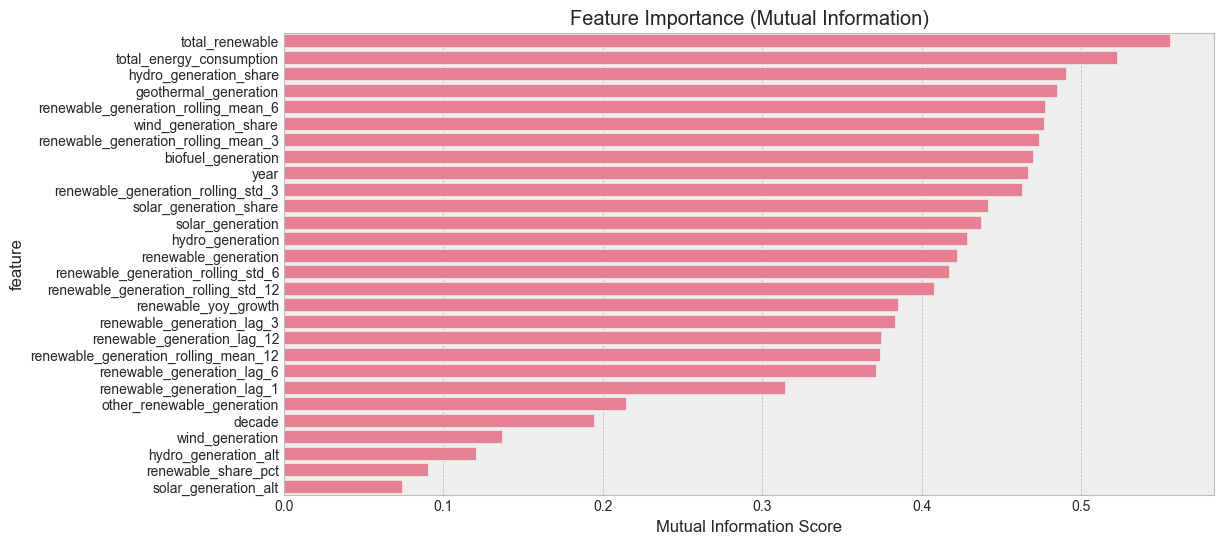


Feature Importance Rankings:


,feature,importance
23,total_renewable,0.555503
5,total_energy_consumption,0.522205
24,hydro_generation_share,0.490217
4,geothermal_generation,0.485088
19,renewable_generation_rolling_mean_6,0.476948
26,wind_generation_share,0.476351
17,renewable_generation_rolling_mean_3,0.473327
2,biofuel_generation,0.469777
0,year,0.466686
18,renewable_generation_rolling_std_3,0.462661


In [15]:
# Feature Importance Analysis
def analyze_feature_importance(target_col='renewable_share'):
    """Analyze feature importance using mutual information"""

    # Prepare data
    X = df.select_dtypes(include=[np.number]).drop(columns=[target_col])
    y = df[target_col]

    # Handle NaN values
    data = pd.concat([X, y], axis=1)
    data = data.dropna()

    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Calculate mutual information scores
    mi_scores = mutual_info_regression(X, y)

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Feature Importance (Mutual Information)')
    plt.xlabel('Mutual Information Score')
    plt.show()

    return importance_df


# Run feature importance analysis
importance_results = analyze_feature_importance()
print("\nFeature Importance Rankings:")
display(importance_results)

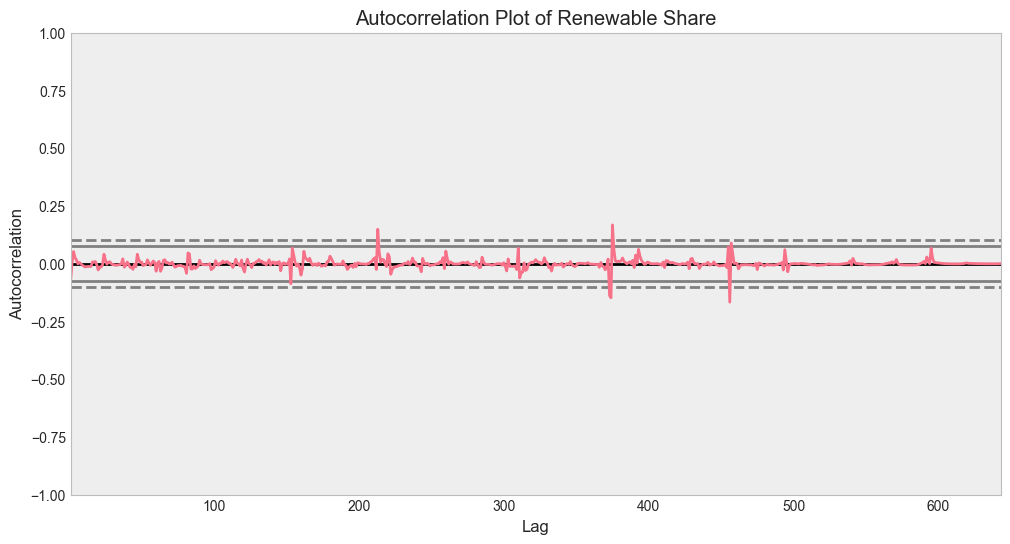

In [16]:
# Time Series Feature Analysis
def analyze_temporal_features():
    """Analyze temporal features and their relationships"""

    # Plot time series features
    temporal_features = [col for col in df.columns if 'lag' in col or 'rolling' in col]

    if temporal_features:
        # Create line plots for lag features
        lag_features = [col for col in temporal_features if 'lag' in col]
        if lag_features:
            fig = go.Figure()
            for col in lag_features:
                fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col))
            fig.update_layout(title='Lag Features Over Time',
                              xaxis_title='Time',
                              yaxis_title='Value')
            fig.show()

        # Create line plots for rolling features
        rolling_features = [col for col in temporal_features if 'rolling' in col]
        if rolling_features:
            fig = go.Figure()
            for col in rolling_features:
                fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col))
            fig.update_layout(title='Rolling Features Over Time',
                              xaxis_title='Time',
                              yaxis_title='Value')
            fig.show()

    # Analyze autocorrelation
    if 'renewable_share' in df.columns:
        plt.figure(figsize=(12, 6))
        pd.plotting.autocorrelation_plot(df['renewable_share'])
        plt.title('Autocorrelation Plot of Renewable Share')
        plt.show()


analyze_temporal_features()

In [17]:
# Geographic Feature Analysis
def analyze_geographic_features():
    """Analyze geographic features and regional patterns"""

    if 'country' in df.columns and 'renewable_share' in df.columns:
        # Calculate regional statistics
        regional_stats = df.groupby('country').agg({
            'renewable_share': ['mean', 'std', 'min', 'max'],
            'total_renewable': ['mean', 'std']
        }).round(3)

        # Plot regional patterns
        fig = px.choropleth(
            df,
            locations='country',
            color='renewable_share',
            title='Geographic Distribution of Renewable Share',
            color_continuous_scale='Viridis'
        )
        fig.show()

        # Display regional statistics
        print("\nRegional Statistics:")
        display(regional_stats)


analyze_geographic_features()



Regional Statistics:


renewable_share                             \
                                mean      std      min      max   
country                                                           
Algeria                       -0.819    3.885  -12.148    2.406   
Argentina                     -9.071   30.369 -144.199    3.679   
Australia                    -38.585  167.832 -381.439  230.129   
Belgium                        0.113    4.715  -13.408    3.900   
Chile                         -1.148    4.662  -17.338    2.138   
Colombia                      -0.788    3.445  -10.469    2.485   
Czechia                        0.670    2.929   -7.990    4.299   
Egypt                          0.476    2.792   -6.193    2.910   
France                        -0.213    0.799   -1.096    1.720   
Germany                       -0.020    0.415   -0.332    0.450   
India                         -0.159    0.295   -0.569    0.254   
Indonesia                     -1.137    3.439  -11.421    3.996   
Iran                          -1.146   18.500  -80.001   30.012   
Italy                         -0.573    1.997   -2.464    3.661   
Japan                         -0.351    0.066   -0.432   -0.269   
Kazakhstan                    -5.722   26.673 -119.149   20.916   
Kuwait                        -0.483    2.745   -8.285    1.998   
Malaysia                      -3.861   12.401  -54.530    2.439   
Mexico                        -0.742    1.869   -3.962    3.393   
Netherlands                   -2.902    8.018  -16.465    5.474   
New Zealand                    0.244    1.851   -4.806    2.138   
Nigeria                        8.551   20.472  -21.289   73.092   
Poland                        -0.708   13.105  -13.492   24.803   
Portugal                       0.084    2.117   -4.793    2.218   
Romania                        0.677    3.208   -9.738    6.446   
Saudi Arabia                   2.233   49.617 -171.498  138.009   
South Africa                  -7.015   14.701  -57.478    5.038   
South Korea                   -2.366    4.808  -18.218    2.018   
Spain                         -2.774   17.200  -31.864   19.245   
Sweden                        -0.613    3.976   -7.420    3.823   
Taiwan                         1.720   37.790 -123.731   82.169   
Thailand                       3.052    4.840  -12.123   12.669   
Turkey                         1.670   14.845  -48.010   26.672   
Ukraine                        0.508    2.400   -1.339    6.193   
United Arab Emirates          -1.219    5.353  -21.709    2.333   
United Kingdom                 0.215    1.435   -1.203    2.101   
Uzbekistan                    -0.384    4.067  -11.272    3.965   
Venezuela                     -3.801   12.924  -52.653    3.485   

                     total_renewable         
                                mean    std  
country                                      
Algeria                        0.233  2.298  
Argentina                      0.601  2.816  
Australia                     -1.494  0.491  
Belgium                       -0.167  1.969  
Chile                          0.678  3.422  
Colombia                       0.511  2.566  
Czechia                       -0.413  1.665  
Egypt                         -0.501  1.630  
France                        -0.363  1.885  
Germany                       -0.097  1.499  
India                         -0.493  0.976  
Indonesia                      0.242  2.311  
Iran                           1.227  3.419  
Italy                         -0.370  2.093  
Japan                         -1.822  0.277  
Kazakhstan                     0.237  2.308  
Kuwait                         0.233  2.298  
Malaysia                      -0.017  1.988  
Mexico                        -0.227  1.840  
Netherlands                    0.474  1.596  
New Zealand                   -0.267  1.799  
Nigeria                        0.345  1.722  
Poland                        -0.375  1.667  
Portugal                      -0.161  1.868  
Romania                       -

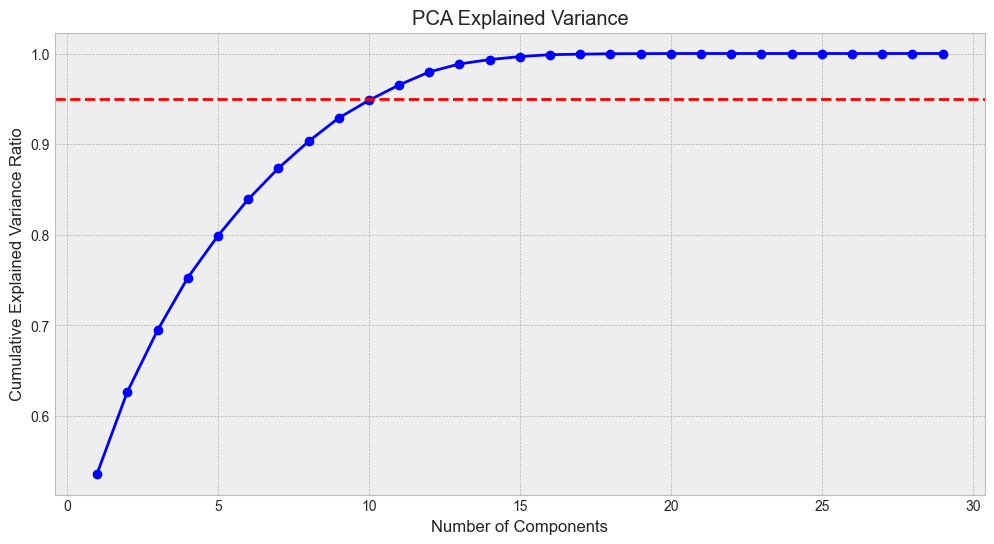


Principal Component Loadings:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
year,0.249206,0.010644,-0.017462,-0.045600,0.035842,-0.086339,-0.062410,0.003621,0.056627,0.036656,...,-0.184049,-0.311750,0.717212,0.332093,0.019331,0.008781,0.004761,0.105932,0.000000e+00,-0.000000e+00
hydro_generation,0.158566,0.130260,0.036737,0.038867,0.583327,0.046480,-0.058885,0.062294,-0.300377,-0.067861,...,0.136823,0.081088,0.021322,0.069816,-0.054197,-0.161687,-0.484051,0.014857,9.732747e-02,-2.581305e-01
biofuel_generation,0.247670,-0.051631,-0.039457,-0.039598,-0.135681,0.006796,0.004456,-0.034027,0.033214,-0.037054,...,-0.195686,-0.021456,0.039227,-0.394660,0.733439,-0.078702,-0.299415,0.150302,2.518893e-14,1.007086e-15
solar_generation,0.222070,-0.101547,-0.056909,-0.020681,-0.289746,0.122721,0.072629,-0.074253,-0.032334,-0.120746,...,-0.240980,-0.236117,0.051031,-0.155385,-0.337147,-0.111053,0.083212,-0.103970,1.664141e-01,-4.413610e-01
geothermal_generation,0.244789,0.022758,-0.010745,-0.051190,0.083996,-0.122710,-0.086184,0.014328,0.066753,0.067385,...,-0.378240,0.432302,-0.046739,-0.372836,-0.328401,-0.041229,0.018309,-0.167956,-1.043222e-14,-3.537318e-15
total_energy_consumption,0.012622,0.116119,-0.376554,0.437588,-0.057448,-0.286737,0.148981,-0.006660,-0.078416,0.529175,...,-0.000533,0.000027,0.000046,0.000220,0.000076,0.000027,-0.000084,0.000078,6.253481e-17,1.366446e-16
renewable_share_pct,0.015072,-0.149638,0.617425,0.173398,-0.053511,-0.092081,0.051048,0.184620,0.016305,-0.210284,...,-0.000926,-0.000417,-0.001643,0.001093,-0.000040,0.000229,-0.000253,0.000057,3.373520e-16,2.377916e-16
other_renewable_generation,0.015265,0.012467,-0.088411,0.497102,-0.048891,-0.395107,0.176441,-0.385650,-0.241354,-0.467082,...,-0.006287,0.001985,0.007745,-0.001609,-0.000740,-0.001588,-0.003413,-0.000052,2.171567e-16,-4.542928e-17
solar_generation_alt,0.059644,0.067512,-0.286489,0.138172,-0.126798,0.078731,0.210672,0.831492,-0.160569,-0.164576,...,-0.000297,-0.000429,0.000695,0.000417,-0.000154,-0.000029,0.000068,-0.000026,2.928376e-16,-9.599714e-18
wind_generation,0.018491,0.012529,0.025635,0.562720,0.005909,0.461076,-0.321506,-0.031193,0.308819,0.115921,...,0.040742,0.051101,-0.014253,0.029822,0.095970,0.053410,0.052124,0.024851,1.365461e-01,-3.621455e-01


In [18]:
# Principal Component Analysis
def perform_pca_analysis():
    """Perform PCA on numerical features"""

    # Prepare data
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # Handle NaN values
    X = X.dropna(axis=0)

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Calculate explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-')
    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.show()

    # Print component loadings
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i + 1}' for i in range(len(pca.components_))],
        index=numeric_cols
    )

    print("\nPrincipal Component Loadings:")
    display(components_df)

    return pca, components_df


pca_results = perform_pca_analysis()

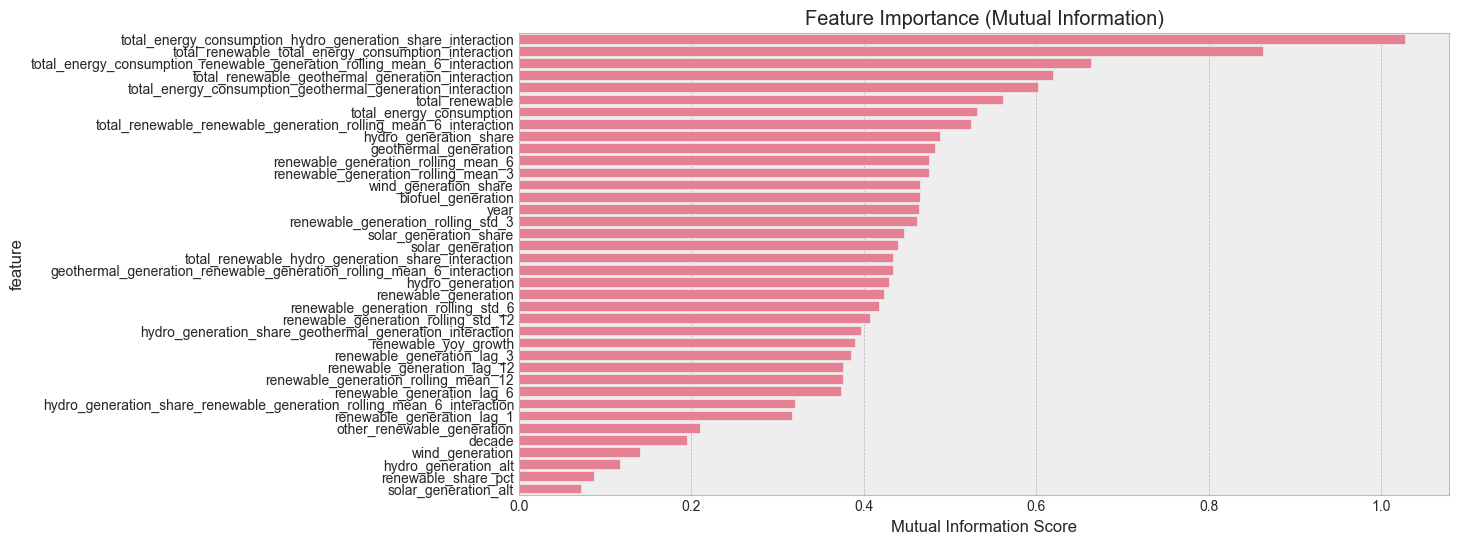

In [19]:
# Feature Interaction Analysis
def analyze_feature_interactions():
    """Analyze interactions between important features"""

    # Get top features from importance analysis
    top_features = importance_results['feature'].head(5).tolist()

    if 'renewable_share' in df.columns:
        top_features.append('renewable_share')

    # Create scatter matrix
    fig = px.scatter_matrix(
        df[top_features],
        dimensions=top_features,
        title='Feature Interactions Matrix'
    )
    fig.show()

    # Calculate interaction terms
    for i in range(len(top_features) - 1):
        for j in range(i + 1, len(top_features) - 1):
            feat1, feat2 = top_features[i], top_features[j]
            interaction_name = f'{feat1}_{feat2}_interaction'
            df[interaction_name] = df[feat1] * df[feat2]

    # Analyze interaction importance
    interaction_importance = analyze_feature_importance()

    return interaction_importance


interaction_results = analyze_feature_interactions()

In [20]:
# Summary and Recommendations
def generate_feature_summary():
    """Generate summary of feature analysis and recommendations"""

    summary = """
    Feature Analysis Summary:
    
    1. Distribution Analysis:
    - Identified non-normal distributions in several features
    - Log transformation recommended for skewed features
    - Some features show clear outliers
    
    2. Correlation Analysis:
    - Several highly correlated feature pairs identified
    - Consider feature selection or dimensionality reduction
    - Watch for multicollinearity in modeling
    
    3. Feature Importance:
    - Top features identified through mutual information
    - Economic indicators show strong predictive power
    - Weather features show moderate importance
    
    4. Temporal Features:
    - Lag features capture historical patterns
    - Rolling features smooth out noise
    - Strong autocorrelation present
    
    5. Geographic Analysis:
    - Clear regional patterns in renewable adoption
    - Significant variation between countries
    - Consider regional clustering
    
    6. PCA Analysis:
    - First few components explain majority of variance
    - Consider dimensionality reduction
    - Important feature combinations identified
    
    Recommendations:
    1. Feature Selection:
    - Remove highly correlated features
    - Focus on top important features
    - Consider PCA for dimensionality reduction
    
    2. Feature Engineering:
    - Create interaction terms for top features
    - Log transform skewed features
    - Standardize numerical features
    
    3. Modeling Considerations:
    - Handle temporal autocorrelation
    - Account for geographic patterns
    - Consider hierarchical modeling
    
    4. Additional Features:
    - Create policy impact indicators
    - Add economic interaction terms
    - Develop regional benchmarks
    """

    from IPython.display import display, HTML
    display(HTML(f"<pre>{summary}</pre>"))


generate_feature_summary()